#1. Importation des bibliotheques


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.feature import hog
from sklearn.model_selection import cross_val_score


# 2. Chargement et préparation des données

In [ ]:
# Charger le dataset Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Supprimer la classe 6
train_filter = y_train != 6
test_filter = y_test != 6

# Appliquer le filtre pour obtenir les données sans la classe 6
x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Relabeling les classes après suppression de la classe 6
y_train = np.where(y_train > 6, y_train - 1, y_train)  # Décaler les labels au-dessus de 6
y_test = np.where(y_test > 6, y_test - 1, y_test)

# Normaliser les images (valeurs entre 0 et 1)
x_train, x_test = x_train / 255.0, x_test / 255.0

# Applatir les images pour les modèles scikit-learn
x_train_flat = x_train.reshape(-1, 28*28)
x_test_flat = x_test.reshape(-1, 28*28)

# Vérification de la forme des données après filtrage
print(f"x_train shape: {x_train.shape}, x_test shape: {x_test.shape}")


x_train shape: (54000, 28, 28), x_test shape: (9000, 28, 28)


# 3. Division du Data 80/20

In [ ]:
# Normalize the data to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten the images (28x28 images become 784-dimensional vectors)
x_train = x_train.reshape(x_train.shape[0], 28*28)
x_test = x_test.reshape(x_test.shape[0], 28*28)

# Combine the training and testing data into one dataset
X_combined = np.concatenate((x_train, x_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

# Split the combined dataset into 80% training and 20% testing
x_train_final, x_test_final, y_train_final, y_test_final = train_test_split(
    X_combined, y_combined, test_size=0.2, random_state=42)

# Check the size of the final split data
print(f"Final training data size (X_train_final): {x_train_final.shape}")
print(f"Final training labels size (y_train_final): {y_train_final.shape}")
print(f"Final test data size (X_test_final): {x_test_final.shape}")
print(f"Final test labels size (y_test_final): {y_test_final.shape}")


Final training data size (X_train_final): (50400, 784)
Final training labels size (y_train_final): (50400,)
Final test data size (X_test_final): (12600, 784)
Final test labels size (y_test_final): (12600,)


In [ ]:

class_names = [
    'T-shirt/top', 'Pantalon', 'Pull-over', 'Robe', 'Manteau',
    'Sandale', 'Baskets', 'Sac à main', 'Bottes'
]


# 4. Entraîner le modèle SVM

In [ ]:

# Initialiser et entraîner le modèle SVM
svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(x_train_final, y_train_final)

# Prédire sur les données de test
y_pred_svm = svm.predict(x_test_final)

# Calculer l'exactitude sur les données d'entraînement
train_accuracy_svm = svm.score(x_train_final, y_train_final)

# Calculer l'exactitude sur les données de test
test_accuracy_svm = svm.score(x_test_final, y_test_final)

# Afficher l'exactitude sur les données d'entraînement et de test
print(f"Train Accuracy: {train_accuracy_svm}")
print(f"Test Accuracy: {test_accuracy_svm}")



Train Accuracy: 0.9849404761904762
Test Accuracy: 0.9449206349206349


# 5. Entraîner le modèle XGB

In [ ]:
# Initialiser et entraîner le modèle XGBoost
xgb = XGBClassifier( use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(x_train_final, y_train_final)

# Prédire sur les données de test
y_pred_xgb = xgb.predict(x_test_final)

# Calculer l'exactitude sur les données d'entraînement
train_accuracy_xgb = xgb.score(x_train_final, y_train_final)

# Calculer l'exactitude sur les données de test
test_accuracy_xgb = xgb.score(x_test_final, y_test_final)

# Afficher l'exactitude sur les données d'entraînement et de test
print(f"Train Accuracy (xgb): {train_accuracy_xgb}")
print(f"Test Accuracy (xgb): {test_accuracy_xgb}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:59:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train Accuracy (xgb): 1.0
Test Accuracy (xgb): 0.9486507936507936


# 6. Rapport de classification des deux modeles SVM et XGB

In [ ]:
print("SVM Classification Report:")
print(classification_report(y_test_final, y_pred_svm))

print("XGBoost Classification Report:")
print(classification_report(y_test_final, y_pred_xgb))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1377
           1       0.99      0.98      0.99      1442
           2       0.90      0.89      0.89      1421
           3       0.93      0.92      0.93      1366
           4       0.89      0.89      0.89      1409
           5       0.97      0.97      0.97      1376
           6       0.95      0.96      0.96      1428
           7       0.97      0.98      0.98      1429
           8       0.97      0.96      0.97      1352

    accuracy                           0.94     12600
   macro avg       0.94      0.94      0.94     12600
weighted avg       0.94      0.94      0.94     12600

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1377
           1       0.99      0.98      0.99      1442
           2       0.91      0.88      0.89      1421
           3       0

# 7. Matrice de confusions des deux modeles SVM et XGB

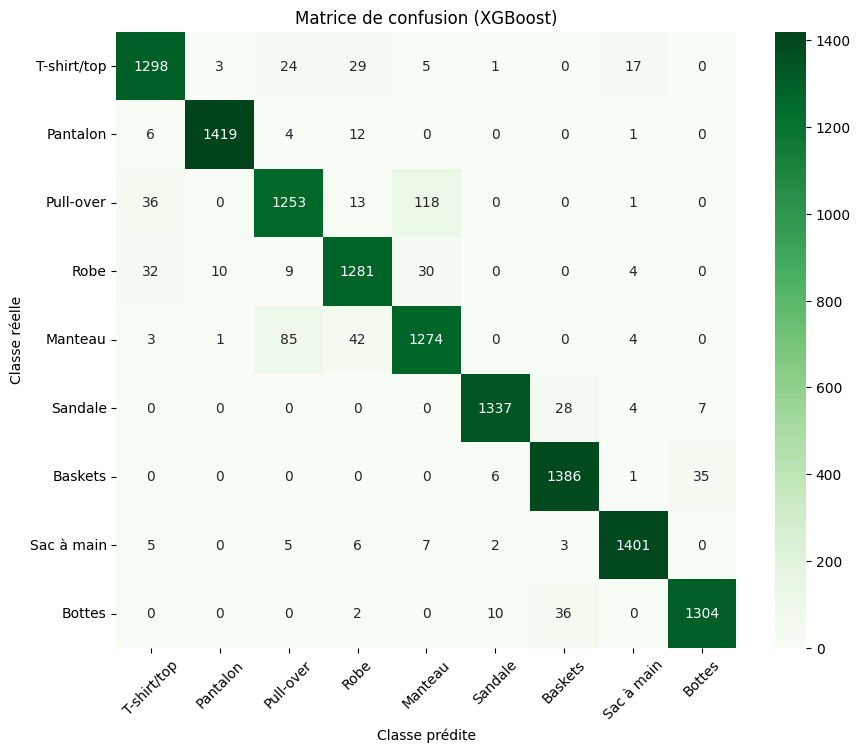

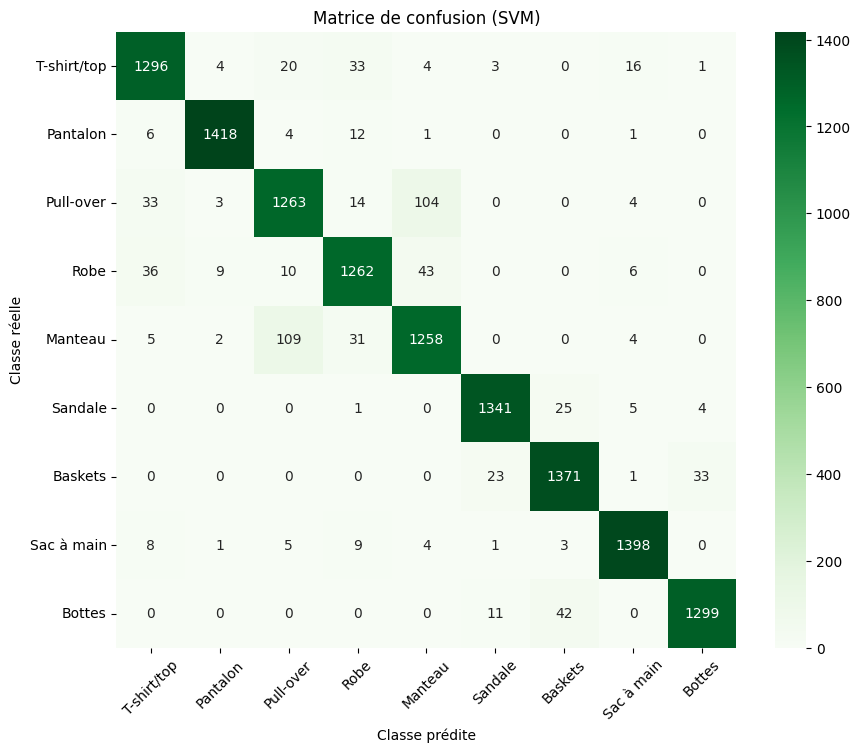

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Fonction pour afficher la matrice de confusion et le rapport de classification
def evaluate_model(model_name, y_test_final, y_pred, class_names):
    # Calculer la matrice de confusion
    conf_matrix = confusion_matrix(y_test_final, y_pred)

    # Visualiser la matrice de confusion
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Matrice de confusion ({model_name})")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    plt.xticks(rotation=45)  # Inclinaison des noms des classes pour une meilleure lisibilité
    plt.yticks(rotation=0)   # Garde les noms des classes verticalement
    plt.show()

# Évaluation des modèles
models_predictions = {
    "XGBoost": y_pred_xgb,
    "SVM": y_pred_svm,
}

# Boucle sur chaque modèle pour afficher les résultats
for model_name, y_pred in models_predictions.items():
    evaluate_model(model_name, y_test_final, y_pred, class_names)


# Cross validation

# 1.   SVM




In [ ]:

# Utilisation d'un modèle SVC
svc_model = SVC(kernel='rbf', C=10, gamma='scale')

# Appliquer une validation croisée (5-fold)
scores_svc = cross_val_score(svc_model, x_train_final, y_train_final, cv=5, scoring='accuracy')

print("Scores pour SVC (5-fold):", scores_svc)
print("Score moyen pour SVC:", np.mean(scores_svc))




Scores pour SVC (5-fold): [0.93878968 0.94275794 0.93839286 0.94176587 0.93789683]
Score moyen pour SVC: 0.9399206349206348



# 2.   XGBoost



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import xgboost as xgb
import numpy as np

# Initialiser le modèle XGBoost
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Initialiser la validation croisée avec 5 plis
kf = StratifiedKFold(n_splits=5)

# Liste pour stocker les scores
cv_scores = []

# Boucle pour chaque pli de la validation croisée
for train_index, val_index in kf.split(x_train_final, y_train_final):
    # Diviser les données en entraînement et validation
    X_train, X_val = x_train_final[train_index], x_train_final[val_index]
    y_train, y_val = y_train_final[train_index], y_train_final[val_index]

    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédire sur le jeu de validation
    y_pred = model.predict(X_val)

    # Calculer l'exactitude et l'ajouter à la liste
    accuracy = accuracy_score(y_val, y_pred)
    cv_scores.append(accuracy)

# Afficher les scores de validation croisée et la moyenne
print(f"Scores de validation croisée (5 plis): {cv_scores}")
print(f"Précision moyenne après validation croisée: {np.mean(cv_scores)}")
print(f"Écart-type des scores: {np.std(cv_scores)}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:30:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:37:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:43:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:50:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:56:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Scores de validation croisée (5 plis): [0.94375, 0.9411706349206349, 0.9435515873015873, 0.9434523809523809, 0.9385912698412698]
Précision moyenne après validation croisée: 0.9421031746031746
Écart-type des scores: 0.0019916523954491365
